In [ ]:
from torchvision import datasets, transforms

BATCH_SIZE = 32
train_dataset = datasets.FashionMNIST(
    root='./data',  # 데이터 저장 경로
    train=True,  # 학습용 데이터셋
    download=True,  # 데이터가 없으면 다운로드
    transform=transforms.ToTensor()  # 텐서로 변환
)

In [3]:
test_dataset = datasets.FashionMNIST(
    root='./data',
    train=False, # 테스트용 데이터셋(이 부분만 달라짐)
    download=True,
    transform=transforms.ToTensor()
)

In [4]:
from torch.utils.data import Dataset

class BinaryMNIST(Dataset):
    def __init__(self, dataset, class_1, class_2):
        self.dataset = dataset
        self.indices = [i for i, (_, label) in enumerate(dataset) 
                        if label in [class_1, class_2]] # 원하는 클래스의 인덱스만
        self.class_map = {class_1: 0, class_2: 1} # class_1은 0으로, class_2는 1로
        
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        image, label = self.dataset[self.indices[idx]] # idx번째 데이터
        return image, torch.tensor(self.class_map[label]) # 레이블 바꾸기
        # label.item() -> label

In [5]:
binary_train_dataset = BinaryMNIST(train_dataset, 2, 6)  # 2번과 6번의 이항 분류
binary_test_dataset = BinaryMNIST(test_dataset, 2, 6)

In [6]:
import torch
import torch.nn as nn

class BinaryClassifier(nn.Module):
    def __init__(self, input_size=784):  # MNIST의 경우 28*28=784
        super().__init__()
        self.flatten = nn.Flatten()  # 입력 이미지를 1차원으로 평탄화
        self.linear = nn.Linear(input_size, 1)  # 한 개의 출력 뉴런
        self.sigmoid = nn.Sigmoid()  # 시그모이드 활성화 함수

    def forward(self, x): # 모형에 x가 입력되면
        x = self.flatten(x) # 위에서 정의한 레이어들을 
        x = self.linear(x) # 순서대로
        x = self.sigmoid(x) # 통과하여
        return x # 결과를 반환
model = BinaryClassifier()


In [7]:
criterion = nn.BCELoss() # 이항분류이므로 BCELoss

In [8]:
optimizer = torch.optim.RAdam(model.parameters())

In [9]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_loader = DataLoader(
    binary_train_dataset,  # 훈련 데이터
    batch_size=BATCH_SIZE,  # 32개씩
    shuffle=True)  # 섞어서(미니배치마다 조합이 다양하도록)

test_loader = DataLoader(
    binary_test_dataset,  # 테스트 데이터
    batch_size=BATCH_SIZE,  # 32개씩
    shuffle=False)  # 섞지 말고


In [10]:
def fit(model, train_loader, criterion, optimizer, epochs):
    model.train()  # 훈련 모드
    for epoch in range(epochs):
        for i, (x, y) in enumerate(train_loader):  # 미니배치마다
            optimizer.zero_grad()  # 기울기 초기화
            y_hat = model(x)  # 모형 예측
            loss = criterion(y_hat, y.float().view_as(y_hat))  # 오차 계산
            loss.backward()  # 기울기 계산
            optimizer.step()  # 가중치 수정
            print(f'Epoch: {epoch}, Batch: {i}, Loss: {loss.item()}')


In [ ]:
fit(model, train_loader, criterion, optimizer, epochs=3) # 전체 데이터를 3회 학습

In [12]:
total = 0
correct = 0
mean_loss = 0
model.eval() # 모형을 평가 상태로
for i, (x, y) in enumerate(test_loader):
    y_hat = model(x)
    pred = (y_hat.squeeze() > 0.5).long()  # 0.5를 기준으로 0, 1로 변환
    total += y.size(0) # y의 개수
    correct += (pred == y).sum().item() # 정답과 일치하는 경우
    loss = criterion(y_hat, y.float().view_as(y_hat)) # 손실
    mean_loss -= (mean_loss - loss.item()) / (i + 1) # 평균 손실 계산
print(f'Accuracy: {correct / total}, Mean Loss: {mean_loss}')


Accuracy: 0.822, Mean Loss: 0.43988630743253804


In [14]:
import numpy as np
y_true = []  # 정답
y_prob = []  # 예측한 확률
with torch.no_grad():  # 그래디언트 계산 비활성화
    for x, y in test_loader:
        probs = model(x)
        y_true.extend(y.numpy())  # 정답에 추가
        y_prob.extend(probs.squeeze().numpy())  # 확률에 추가
y_prob = np.array(y_prob)  # 배열로 변환


In [51]:
threshold = 0.5  # 문턱값
y_pred = np.where(y_prob > threshold, 1, 0) # 문턱값보다 크면 1 아니면 0

# 혼동행렬 구하기
from sklearn.metrics import *
confusion_matrix(y_true, y_pred)


array([[864, 136],
       [220, 780]], dtype=int64)

In [52]:
(864+780) / (864+136+220+780)

0.822

In [53]:
accuracy_score(y_true, y_pred)

0.822

In [54]:
precision_score(y_true, y_pred)

0.851528384279476

In [55]:
recall_score(y_true, y_pred)

0.78

In [56]:
f1_score(y_true, y_pred)

0.81419624217119

그래서 진위 양성 음성 이렇게 얘기하는데 이 양성 음성은 예측을 기준으로 얘기를 하고요

근데 사실 현실에서는 개별 개별 케이스에서 우리가 진위는 알기 어려운 경우가 많이 있습니다

그래서 우리가 이제 항상 예측을 기준으로 얘기를 하게 되고요 그래서 한번 우리가 이제 모델에다가 이 확률을 넣어 가지고 확률을 전부 수집을 해 보면 여기 이제 `y_true`에는 실제 정답을 넣고요

`y_prob`에는 우리가 예측한 확률을 넣는 거예요

그래서 이거를 `y_true`랑 `y_prob`에다가 쭉 수집을 해 보면 

그럼 이제 `y_true`에는 0110011 이렇게 쭉 가고요

이게 이제 정답이죠

그 다음에 `y_prob`에는 확률로 0.07 0.7 0.7 이렇게 갑니다

그럼

정답이 지금 011인데 아까도 얘기 드렸지만 확률은 항상 1일 확률이죠

그럼 0.07이니까 이건 0이라고 봐도 될 거고 이건 0.7이니까 1이라고 봐도 될 거고 여기는 0.7이니까 이거는 1이라고 봐도 될 거고 뭐 이런 식으로 예측할 수 있는데 앞에 3개 기준으로 하면은 뭐 3개는 거의 다 맞았다고 할 수 있겠죠

그래서 210쪽에 `y_true`랑 정답이랑 우리가 실제로 그 개별 케이스에서 예측한 확률이 어떻게 되는지 이거 수집하는 이 코드를 실행을 하시면 되겠습니다

그래서 우리가 이제 혼동 행렬을 만들 건데 혼동 행렬을 만들려면은 이 확률을 가지고 예측을 해야 되는데 우리가 이제 211쪽으로 넘어가서 우리가 이제 문턱값을 50%로 정해서 50%보다 높으면 1 50%보다 낮으면 2 낮으면 0 직관적으로 그렇게 할 수 있겠죠

그래서 이제 최종 예측을 할 겁니다

`y_pred`가 우리의 예측이 되고요 그래서 이 컴퓨전 매트릭스 함수에다 넣으면 `y_true`하고 `y_pred`를 이제 조합을 해 가지고 4가지 경우가 나오는데 저랑 숫자는 조금 다르실 수 있어요

대략 아마 비슷할 건데 그래서 이 숫자가 순서대로 슬라이드에 있는 숫자랑 순서가 똑같습니다

이 순서대로 숫자가 나오는데 저 같은 경우는 864, 136이니까 864 136 그 다음에 220, 780 이렇게 됐죠

220 720 그래서 이 숫자를 순서대로 864가 진음성 136이 위향성 220이 위음성 780이 진향성이구나 이 순서랑 슬라이드 순서를 제가 맞춰놨으니까 그렇게 보시면 돼요



자 그래서 이렇게 우리가 이제 구별을 해 봤는데 그러면 이제 네 가지 케이스가 이렇게 있는데 요거를 이제 잘 보면 점수를 여러 가지 방식으로 산출할 수 있습니다

첫 번째 방법은 정확도 라는 건데요 어차피 여기도 진음성이고 어?

여기도 이제 진양성인데 어쨌든 음성이든 양성이든 진은 진이잖아요

맞은건 맞은 거란 말이에요

그러면은 전체 4가지 케이스 중에 요 두 가지 케이스의 비율이 얼마가 되느냐

고거를 정확도 영어로는 Accuracy라고 부릅니다

이건 하여간 몇 개 맞았냐

이겁니다

묻지도 따지지도 않고 음성인지 양성인지 따지지 않고 몇 개 맞았냐

이러면 이제 정확도가 되고요 그래서 전체 중에 True Positive and True Negative 그래서 전체 중에 True Positive and True Negative 비율을 계산을 한 겁니다

그래서 이건 통상적으로 음성 양성 구분에 별로 관심이 없는 경우에 하여간 그냥 맞추기만 하면 되는 경우에 쓰는데 숫자 0하고 1을 구분한다던가 아니면 강아지 고양이를 구분한다던가 이럴 때는 특별히 어느 쪽에 더 관심 있는 건 아니죠

그냥 뭐든지 맞추기만 하면 됩니다

보통은 우리가 이제 예를 들어서 어떤 불량품을 찾아낸다 불량품하고 정상품을 찾아낸다

보통은 불량품을 찾아내는데 좀 더 관심이 많이 있거든요

품질 검사를 하면 불량품을 잘 찾아내는 게 중요하잖아요

정상품 잘 찾아내는 거야

대충 다 정상품이니까 정상품은 그러려니 하는데 불량품을 잘 찾아야 됩니다

여러분들이 건강검진을 가면 뭔가 병을 잘 찾는 게 중요하지 건강한 걸 확인하는 거는 기분은 좋지만 사실 그렇게 중요한 건 아니죠

뭔가 혹시 내가 모르는 병이 있나 이런 거를 찾는 게 더 중요하잖아요

그러니까 약간 보통은 이 이 Mm 어만지 teenager 영어 세상距 부반입니다

그 그 둘다 사실을 하다고 해요

그냥 그ea 점수를 매기는데 그중에 하나가 이제 정밀도 영어로는 프리 시져원이라고 하는 방법이 있습니다

이게 펄스 파지티브 이 둘 중에 트루 파지티브가 얼마나 많으냐

이거를 따져요

이거는 주로 어떤 경우에 많이 쓰냐면 우리가 뭔가 예측을 양성으로 하는 경우에 뭔가 행동이 취해지고 그 행동에 따라서 뭔가

결과가 나오는데 우리가 네거티브로 한 경우에는 그 뒷일이 아무것도 없으면 우리가 이쪽은 따질 필요가 없는 거죠

어차피 아무 결과가 없으니까 예를 들면 우리가 신입사원 채용을 한다 신입사원 채용 그래서 지원자하고 왔는데 보니까 똘똘하고 성격도 좋아 보이고 그래 합격 근데 일을 잘해요

그럼 좋죠

근데 일을 못해요

아 괴롭죠

근데 사실은 우리 회사가 찾고 있던 그 인재였는데 우리가 실수로 떨어뜨렸습니다 인상이 나빠 보여가지고 떨어뜨렸어요

그럼 어떻게 됩니까?

뭐 아무 일도 없죠

어디 가서 잘 살겠죠

물론 전 세계에 딱 한 명 있는 인재였다

이러면 곤란한데 보통은 안 뽑으면 그만이란 말이에요

예를 들면 삼성중공업 면접 온 사람이 하나오션인가요

지금 이름이 거기로 갔어요

삼성중공업 입장에서 뭔 문제입니까 아무 문제도 없죠

무슨 일이 있었는지 기억도 못 할걸요

우리가 신입사원 여러분 면접 가셔가지고 여러분 면접관으로 들어가셨을 때 떨어뜨린 사람 기억하십니까?

기억 안 나죠?

그렇죠?

되게 이상하게 면접을 깽판치지 않는 이상 기억도 안 난단 말이에요

내가 그런 사람을 떨어뜨린 적이 있었던가?

이러면서 기억이 안 납니다

그래서 그 연구 중에 전문성 발전에 관한 연구가 있는데 사람이 경력에 따라서 전문성이 경력이 길어지면 이제 전문성이 이렇게 올라가는데 직업에 따라서 올라가는 속도가 다르거든요

똑같은 경력에 동일 경력 대비 전문성 올라가는 속도가 다르거든요?

보통 기계 분야에 있는 사람들이 전문성이 제일 빨리 올라갑니다

왜냐하면 기계는 정확하거든요

내가 뭘 잘못하면 정확하게 안 되고 뭘 잘하면 정확하게 되고 그래서 전문성이 빨리빨리 올라가요

왜냐하면 내가 해보면 아니까 근데 이제 전문성이 느리게 올라가는 사람들이 주로 어떤 사람들이냐면 사람을 다루는 분야의 사람들이 전문성 발달이 느립니다

주로 이제 채용, 정신과 의사, 학생 선발 담당자 주로 이제 채용, 정신과 의사, 학생 선발 담당자 보통 이제 대학의 뭐라고 하죠

갑자기 이름이 기억이 안나

입학사정관 입학사정관 왜냐면 보통 이제 이런 직업들은 뭔가

잘잘못이 결과가 나오려면 되게 오래 걸려요

예를 들면 여러분이 대학의 입학사정관이다

어떤 학생이 되게 똑똑해 보여요

뽑았어요

근데 그 학생이 정말로 잘 뽑았는지 안 뽑았는지를 알려면 최소한 4년은 기다려야 됩니다

남학생들은 이제 군대까지 갔다 오니까 6년은 기다려봐야 아 내가 6년 전에 뽑았던 그 학생들은 잘 뽑았는지 안 뽑았는지 알려면 최소한 4년은 기다려야 됩니다

남학생들은 이제 군대까지 갔다 오니까 6년은 기다려봐야 남학생 잘할 줄 알았더니 잘못 봤구나

근데 경력에 내가 그 학교에 30년 경력이 있다 그러면 벌써 6년이 지났으면 내 경력 20%는 이미 날라갔어요

그냥 채용도 마찬가지인데 아 훌륭한 인재군 뽑았으면 뭐 그래도 보통 이제 회사들이 정규직으로 뽑으면 당장 일 잘 할 사람을 뽑는 경우도 있지만 보통 이제 신입채용 같은 경우는 좀 한 3년 이렇게 길게 내다보고 뽑는단 말이에요

문제는 이제 3년쯤 지나면 내가 이 사람을 뽑았던가 이렇게 된단 말이에요

그래서 전문성 발전 속도가 굉장히 느립니다 시간이 오래 걸려요

거기다가 이제 심지어 채용이나 입학사정관은 더 문제가 뭐냐면 떨어뜨린 사람이 어떻게 되는지 알 방법이 없어요

내가 떨어뜨렸는데 그 사람이 어디 가서 어떻게 사는지 모르거든요

내가 떨어뜨린 사람이 경쟁사로 가서 굉장히 훌륭한 인재로 컸다

어떻게 알겠어요

알 수가 없죠

그래서 이제 뭐 이런 직업이 나쁘다

이런 건 아니고 성장 속도가 느릴 수밖에 없는 거죠

우리가 피드백을 잘 못 받으니까 그래서 이제 이공계가 좋은 게 다 이유가 있습니다

이공계가 뭔가

빨리빨리 배울 수 있는 분야가 이공계에 많죠

어쨌든 신입사원 채용 같은 경우는 우리가 이제 이쪽에 해당되는 케이스는 뭐 몰라요

알 수가 없습니다 어디 가서 뭘 하는지도 모르고 알 수가 없죠

그래서 예측을 양성으로 한 경우에만 뭔가 행동이 있고 결과가 있고 음성으로 한 경우에는 행동을 안 하니까 결과가 없거나 뭐 몰라요

그러니까 이건 평가할 수가 없습니다

그래서 이런 경우에는 대체로 정밀도를 씁니다

신입사원 채용 말고도 또 뭐가 있을까요

예를 들면 비슷한 거 이제 결혼이 있죠

결혼은 야 이 사람이 내 사람이다 결혼을 했어요 행복하게 살면 좋은데 별로 행복하지 않아요

그러면 이제 결혼 잘못한 거죠

근데 만약에 이제 예를 들면 내가 고등학교 때 만났던 여자친구다

남자친구다

근데 뭐 그때 대학 가면서 헤어졌어요

그럼 어디 가서 뭐 하고 사는지 알 게 뭡니까

그죠 가끔 이제 다시 만나고 싶다 뭐 의미 없는 얘기죠

다시 만나보면 아 이런 사람이었나 뭐 이럴 수도 있고 뭐 알 수 없습니다

알 수 없으니까 뭐 내가 결혼 안 하는 사람 어디 가서 뭐 하고 사는지 낼 바 아니에요

그죠 알아서 잘 살겠죠

뭐 잘 살라고 하세요

뭐 결혼도 그렇고 또 뭐가 있습니까

투자 같은 경우도 있죠

투자 같은 경우도 내가 산 주식이 오르는 게 중요하지

그죠

산 주식이 떨어지면 곤란하고 오르는 거면 좋은 거고 내가 안 산 주식은 물론 오르면 배는 아픕니다

배는 아프지만 여러분 재산상에 무슨 변화가 있냐면 아무 변화도 없죠

그래서 이것도 내가 안 오를 거라고 생각하면 안 사니까 여러분한테 아무 타격이 없어요

물론 이제 배 아프거나 억울하거나 이럴 수 있습니다

저도 맨날 이제 엔비디아 주가 올랐다는 소식만 들으면 뒷목이 아픈데 뭐 아무 상관없습니다

지금 뭐 딴 거 좋은 거 사면 되죠 뭐 그래서 이런 거 투자도 그렇고 그다음에 이제 추천 그 유튜브 같은 거 이제 들어가면 여러분이 뭐 안 해도 이제 화면에 이렇게 재밌어 보이는 영상이 있어요

그래서 이런 거 투자도 그렇고 그다음에 이제 추천 유튜브 같은 거 이제 들어가면 여러분이 뭐 안 해도 이제 화면에 이렇게 재밌어 보이는 영상이 있어요

그럼 이 중에서 여러분한테 재밌는 영상이 있으면 됩니다

유튜브에 영상이 수억 개가 있는데 그걸 여러분이 다 볼 순 없단 말이에요 있는 거 중에 재밌는 게 있으면 땡인 거죠

그래서 뭐 이런 것들은 다 이제 정밀도로 평가하는 것이 맞다 전부 보면은 양성 예측에만 뭔가 액션이 있고 음성 예측은 그냥 빠이빠이 한 다음에 다시 볼 일이 없기 때문에 어차피 점수 자체를 낼 수가 없습니다

이런 거는 이제 정밀도를 계산을 하면 된다

이런 얘기고요 그다음에 이제 정밀도는 좀 특이한 특성이 있는데 뭐냐면은 문턱 값을 높이면은 똑같은 모델로 하더라도 정밀도를 높일 수가 있습니다

무슨 말이냐면 여러분들이 이제 결혼을 생각을 해 보세요 여러분 결혼하신 분들 보면 결혼할 때 얼마나 고민하고 결혼을 하십니까

그죠

아 얘랑 결혼한 게 맞나 생각을 물론 이제 생각 없이 그냥 덜컥 결혼하시는 분도 가끔 있지만 그래도 잘 사실 수 있지만 보통 고민을 많이 한단 말이에요

채용도 그렇죠

채용할 때 많이 고민하시고요 투자할 때 고민 많이 하죠

추천할 때 고민 많이 하죠

왜 고민을 많이 하냐면 고민을 많이 한다는 건 뭐냐면 기준선을 올린다는 거예요

문턱을 올린다 문턱을 올리면 정밀도가 올라갑니다

왜냐하면은 이 중간에가 이제 애매한 케이스들이 있는데 문턱을 올리면 애매한 케이스들이 잘려 나가기 때문에 정밀도를 올리면 문턱을 올리면 정밀도가 올라가요

실제로 해보면 자 여기서 이제 그 애큐러시를 계산을 해 보면 애큐러시는 전체 케이스에 있는 것입니다.

손으로 계산을 해보면 애큐러시는 864 더하기 780 나누기 864 더하기 136 더하기 220 더하기 780 이렇게 됩니다.

82.2%인데 손으로 계산하시는 대신에 여기 sk런.matrix에 accuracy score라는 함수가 있어요.

accuracy score 그래서 여기다가 똑같이 ytrue랑 yfree 를 넣어주시면 똑같이 0.822 이렇게 나옵니다.

직접 계산하실 필요는 없겠죠

한번 계산해 보세요

맞는지 그 다음에 precision score는 accuracy 대신에 precision score 이렇게 하면은 0.85 이렇게 나오는데 왜 0.85냐 하면 두 개 136하고 780 중에서 precision score는 accuracy 대신에 precision score 이렇게 하면은 0.85 이렇게 나오는데 왜 0.85냐 하면 두 개 136하고 780 중에서 %라 그렇습니다.

그래서 accuracy score precision score는 강의 자료 몇쪽에 있냐면 여기 228쪽에 있습니다.

이거 보시고 하시면 되고요.

그래서 해보신 다음에 뭘 해보냐면 여기 문턱값 쓰레수를 드릴게요.

여기 문턱값 Threshold가 있죠

이거를 0.5에서 0.6으로 한번 높여 보세요 그러면 지금 Precision이 0.85에서 0.89로 올라갔죠

아무것도 안 했는데 모델이 똑같은 모델인데 애매한 케이스를 0.5에서 0.6 사이에 애매한 케이스를 떨어버렸기 때문에 좀 더 확실한 것만 남게 됩니다

그래서 Precision이 올라가요

그래서 여기 Threshold를 올려보세요

0.7 이렇게 올리면 Precision이 0.92로 올라갑니다

그래서 여기 문턱값을 바꿔가면서 반대로 낮추면 어떻게 되겠어요

예를 들어 문턱을 낮추면 채용을 하는데 문턱을 낮추면 이상한 사람들이 자꾸 뽑혀 있겠죠

문턱을 낮추면 Precision이 0.92로 올라갑니다

Precision이 내려갑니다

여기 문턱을 바꿔가면서 Precision이 어떻게 바뀌는지 한번 보세요 여기 문턱을 낮추면 0.92로 올라갑니다

밑에 두 개를 가지고 지표를 낼 수도 있습니다

이렇게 내는 거를 재현도라고 하는데 실제로 양성인 거 중에 얼마나 맞췄냐

관점이 달라요

이건 내가 양성이라고 예측한 거 중에 얼마나 맞췄냐

가 정밀도고 실제로 양성인 거 중에 얼마나 맞췄냐가 재현도인데 이거는 어떤 데 중요하냐면 예를 들면 방역 같은 상황이 중요합니다

예를 들면 우리가 코로나 초기에 코로나 환자를 빨리 격리를 해가지고 확산 속도를 늦추려고 한다

사실 코로나 같은 경우에 질병 같은 경우에 격리를 열심히 한다고 차단이 되지는 않습니다

결국에는 다 퍼지는데 그래도 격리를 열심히 하면 조금 느리게 퍼지는 거죠

근데 이제 그러면 내가 예측을 어떻게 하는지가 중요한데 이런 게 아니고 실제 코로나 환자를 빠짐없이 잘 찾아 가지고 다 격리를 하는 게 중요해요

그런 상황에서는 재현도가 중요합니다

실제로 양성 중에 얼마나 맞췄냐

이거를 맞추는 게 중요하고 여러분이 예를 들면 질병관리청장이라고 생각을 해 보세요 여러분한테 주어진 임무는 코로나 확산을 느리게 하기 위해서 코로나 감염된 사람들을 빨리 빨리 격리를 하는 겁니다

그럼

여러분은 정책을 어떻게 세우시겠어요?

문턱을 높일까요?

낮출까요?

문턱을 낮춰야겠죠

그냥 코로나의 기미만 보이면 으엑 하면은 선생님 격리 그래서 우리 잘 기억을 해 보시면 2020년 벌써 4년 전이라 기억이 가물가물한데 초기에 어땠냐면 일단 외국 갔다 오면 무조건 격리 그 다음에 코로나 확진자랑 밀접 접촉하면 무조건 격리 뭐 하면 그냥 격리 일단 격리 문턱이 되게 낮아요

왜냐하면은 이 제연도를 올리기 위해서 그렇습니다

그 대신에 격리가 된 다음에 풀려나오려면 처음에 어떻게 됐냐면 격리 시설에 들어갔다가 검사를 해 가지고 음성이 두 번 나와야만 풀어져요

그러니까 굉장히 들어가는 건 쉽고 나오는 건 까다롭게 이렇게 한 거죠 그러다가 이제 뭐 어느 정도 퍼지고 나서 이제 약간 격리를 해봤자 이미 다 걸려 가지고 너도 나도 다 걸렸으니까 소용없으니까 이제 기준을 풀어버린 건데 그냥 알아서 집에서 쉬세요

뭐 이렇게 된 건데 초반에는 어떻게 속도를 좀 늦춰 보려고 열심히 격리를 한 거죠

문턱을 낮춰서 제연도는 이제 문턱이 낮으면 올라가고 문턱이 높으면 내려갑니다 정밀도랑 반대예요

그래서 동시에 올릴 수가 없습니다

같은 모델을 쓰는 이상은 하나를 올리면 하나가 떨어져요

그 다음에 이제 특이도라는 게 있는데 특이도는 뭐냐면 제연도랑 똑같은데 제연도는 이 밑에 두 개 중에 얼마나 맞췄냐

요거를 말하는 거고 이게 제연도고 특이도는 이 위에 두 개 중에 음성 실제 음성 두 개 중에 어디를 맞췄냐

이겁니다

근데 이 특이도는 결국엔 요 기준선을 문턱을 높이면 기준선이 이렇게 올라가고 문턱을 낮추면 기준선이 이렇게 내려가는 거라서 문턱을 낮추면 제연도는 올라가는데 특이도는 떨어져요

그리고 이렇게 올리면 특이도는 올라가는데 제연도가 내려갑니다.

그래서 이것도 동시에 올릴 수가 없어요

제연도를 올리면 특이도가 떨어지고 제연도를 낮추면 특이도가 올라갑니다

그래서 이제 방역 같은 상황에서 그 코로나 걸린 사람을 잘 찾아서 격리를 시키면서 동시에 멀쩡한 사람이 잘 돌아다니면서 경제활동을 하게 만드는 정책은 없어요

둘 중에 하나를 골라야 됩니다

강제선택입니다

경제활동을 중시해서 멀쩡한 사람들이 잘 돌아다니게 하든지 그 대신에 코로나가 퍼지는 거는 그냥 감수하고 넘어가든지 아니면 코로나를 억제하기 위해서 멀쩡한 사람이 저는 코로나 안 걸렸는데요 일단 격리 질질질질 이런 상황을 감수하든지 둘 중에 하나지 둘 다 잘하는 방법은 그냥 없어요

그거를 하겠다는 거는 불가능합니다

그거는 약간 과학도 아니고 수학에 도전하는 거예요

그래서 이제 이거가 서로 이제 반대 방향이다

이거를 이해하시는 게 필요하고 그 다음에 이제 특이도는 이게 이제 특이도가 낮으면 어떤 문제가 있느냐

보통 이제 의학에서는 정밀도는 잘 안 보고 이제 제현도랑 특이도를 보는데 의학에서는 보통 제현도라고 안 하고 이제 민감도라는 용어를 씁니다

용어가 되게 많죠

다 외우지 마시고 그냥 그렇구나

나중에 자료 보세요 다 외우려면 머리 아픕니다

그래서 이제 민감도는 제현도랑 똑같은 뜻인데 특이도가 이제 제현도만 높으면 되지

특이도가 낮으면 뭐가 문제냐

특이도가 낮으면 왜 문제냐 하면 이제 이거 코로나 이 자료 제가 코로나 때 만들었는데 코로나 19 검사법이 여러 가지가 있어요

PCR이 있고 이거 코흡해서 하는 거고요

신속 항원 검사는 지금도 이제 요즘에 거의 검사 안 하시죠

이제 동네 병원 가면 해주는 거 근데 이제 장단점이 있는데 이 코흡이는 거는 하루가 있어야 결과가 나오니까 코흡이고 나서 하루 동안 집에서 또 격리하고 있어야 되거든요

근데 이제 동네 병원 가서 하는 거는 30분이면 결과 나옵니다

근데 문제가 뭐냐면 PCR은 민감도랑 특이도가 둘 다 굉장히 높은 방법입니다

근데 병원 가서 하는 거는 민감도도 좀 낮은데 특이도도 좀 낮아요

뭐 특이도 96이면 괜찮은 거 아닌가요

근데 특이도가 96이면 굉장히 심각한 문제가 생깁니다

어떤 문제가 생기냐 우리가 대부분 코로나가 아무리 퍼져도 실제 인구 중에 코로나에 걸린 사람은 별로 그렇게 크지가 않거든요

제일 많이 퍼졌을 때가 우리가 하루에 60만 명 감염될 때인데 하루에 60만 명이라고 해도 우리 인구가 많이 커져서 하루에 60만 명 감염될 때인데 하루에 60만 명이라고 해도 우리 인구가 많이 커져서 우리 인구가 5천만 명인데 그럼 하루에 한 1% 감염되는 거잖아요

그럼 코로나가 한 2주일 간다고 해도 전체 인구 중에 코로나 걸려있는 사람은 뭐 끼케 한 15%?

와 많긴 많네요

어쨌든 많긴 많지만 이게 피크일 때란 말이에요

그러니까 사실 아무리 많이 걸려봤자 이 정도란 말이에요

그렇게 난리가 나도 그러면 어떤 문제가 생기냐 예를 들면 실제 양성이 전체 인구의 1%다

그러면 우리가 이제 만 명 중에 만 명 중에 1%만 코로나에 걸려 있으니까 실제로 코로나 걸린 사람은 100명밖에 안 됩니다

그래서 이제 민감도 98%에 특이도 100%인 어떤 검사가 있다

PCR 같은 이런 검사죠

이런 검사는 정밀도가 100%가 됩니다

왜냐하면 특이도가 100%이기 때문에 실제로 건강한 사람이 양성 판정 나는 경우가 없어요

그러니까 양성 판정이 났다 하면 하여간 이 사람은 코로나 걸린 게 확실합니다

그런데 이제 지금부터는요

그런데 이제 지금부터는요 지금 보시면 특이도 96%에 민감도 90%이니까 숫자로 보면 괜찮아 보이거든요

별 차이 없어 보여요

특이도 100% 민감도 98%이나 특이도 96% 민감도 90%이나 뭐 비슷해 보이는데 이게 뭐 그렇게 문제냐 하면 문제가 되는 게 뭐냐면 실제로 음성인 사람이 어마어마하게 많다는 게 문제입니다 만 명 중에 9900명이 음성인데 그 9900명 중에 4%만 양성으로 오판정이 돼도 양성으로 오판정된 사람이 396명이 돼요

문제가 뭐냐면 실제로 양성인 사람은 어찌 되겠어요?

어찌 되겠어요?

그 중에 민감도가 90%여서 이쪽이 90%이 돼도 압도적으로 이쪽이 많습니다

위 양성이 압도적으로 많아요

그래서 정밀도가 형편없이 떨어집니다

지금 정밀도가 이 두 개의 검사를 보면 특이도 민감도가 별 차이 없어 보이는데 정밀도에 엄청난 차이가 생깁니다

그러니까 이 동네 병원에서 하는 검사를 잘 기억해 보시고 우리 초반에 안 썼거든요

초반에 코로나 초반에는 PCR만 쓰고 신속 항원 검사를 안 했는데 왜냐하면 코로나 초반에 시작했을 때 신속 항원 검사하면 코로나 초반에 특히 코로나 걸린 사람이 거의 없잖아요

1%도 안 됐단 말이에요

그러면 신속 항원 검사하면 다 격리해야 됩니다

온 동네 사람들 다 격리돼 있고 일하는 사람이 아무도 없게 돼요

왜냐하면 정밀도가 너무 떨어지니까 그래서 초반에는 이 검사는 안 쓰는 거죠 못 쓰는 거고 후반에는 나중에는 PCR이 비용이 너무 많이 드니까 약간 사실 동네 병원에서 하는 검사는 사실 좀 별로 쓸모가 없습니다

이게 수치상으로 보면 큰 차이 안 나 보이는데 사실 이제 너무 위양성이 많다 멀쩡한 사람들이 너무 많이 간다

그래서 그냥 안 할 수는 없으니까 하는 거지 사실 큰 의미가 있다고 보기에는 좀 힘든 검사다

이렇게 얘기를 할 수 있습니다

그래서 우리가 이런 수치들을 두루두루 살펴 가지고 우리가 지금 양성이 중요하냐 음성이 중요하냐

그다음에 그중에서도 정밀도가 중요하냐 제연도가 중요하냐

이런 판정을 하고 그래서 이런 거에 따라서 우리가 문턱값을 조정을 해서 만약에 우리가 정밀도가 중요하다 채용 같은 상황이면 문턱을 좀 높이고 그다음에 우리가 방역 같은 상황이면 문턱을 좀 낮추고 근데 또 문턱을 너무 많이 낮출 순 없으니까 적당히 이런 거를 고려를 해서 문턱을 결정을 하게 되죠

그래서 여러분들이 실제로 하실 때는 문턱을 오르락내리락 해 보면서 적절한 문턱을 찾으셔야 됩니다

혼동 행렬을 보면서 그 다음에 저는 이제 문턱을 좀 더 높여야 되거든요

그래서 문턱을 좀 더 높여야 되거든요.

저는 정밀도랑 제연도가 다 중요한데 그럼 어떻게 하나요

이런 경우에는 두 개를 평균을 내요

평균을 내는데 보통 산술평균을 내지 않고 산술평균은 P하고 R을 더한 다음에 2로 나누면 산술평균이라고 하는데요

평균이 세 가지가 있거든요

P 곱하기 R을 한 다음에 루트를 씌우는 기하평균이 있고 그다음에 P분의 1하고 R분의 1을 더해서 2분의 1로 나눈 다음에 역수를 내는 이게 조합평균이라고 하는데 이거를 조합평균을 많이 사용을 합니다.

그래서 둘 다 중요하다

그럼 조합평균을 구하는데 왜 조합평균을 구하느냐 원래는 비율의 평균을 낼 때는 조합평균을 내는 게 맞아요

예를 들면 우리가 거제도에서 부산까지 얼마나 될까요

한 50km 될까요

50km라고 합시다 그러면 50km 거리를 시속 50km로 갔다가 올 때는 길이 막혀 가지고 시속 25km로 왔어요

그러면 나의 평균 속도는 얼마일까요

이거를 50km로 갔다가 25km로 갔으니까 75km 나누기 2 하면 37.5km겠네 라고 하면 땡이죠

왜냐하면 나는 총 갈 때에는 1시간 걸렸고 올 때는 2시간 걸렸으니까 총 3시간 걸렸는데 3시간 동안 총 100km를 왔다 갔다 했으니까 나의 평균 속도는 30.3km 산술평균하고 조합평균을 구해 보시면 숫자가 안 맞는데 왜냐하면 속도라는 게 결국에는 비율이거든요

시간당 거리의 비율이기 때문에 속도 같은 거 평균 낼 때 산술평균 내시면 숫자가 좀 안 맞습니다

아주 크게 안 맞는 건 아닌데 조금 안 맞아요

정밀도나 제연도도 비율이라서 비율 평균 내실 때는 조합평균을 하셔야 된다

근데 뭐 산술평균으로 해도 큰 차이가 안 나니까 사실 뭐 상관없는데 어쨌든 수학적으로는 그렇다

그래서 이제 조합평균을 하셔야 된다.

그래서 조합평균을 구하고요 이거는 뭐 직접 구하실 필요 없이 아예 F1 스코어라는 함수가 있습니다

그래서 여기다 넣으면 정밀도랑 제연도를 평균을 내줍니다

그래서 나는 정밀도도 중요하고 제연도도 중요하다 그러면 두 개 평균 내시면 되겠죠

그래서 우리가 이제 여기 프리시전스코어가 있고 리콜스코어 이렇게 구해 보시면 지금 이제 0.5일 때를 기준으로 해 보면 문턱값이 0.5면 프리시전 0.85, 리콜이 0.78 그 다음에 F1이 0.81 이렇게 나오는데 

만약에 이제 문턱을 한 0.3 이렇게 낮추면 프리시전이 0.85에서 0.72로 프리시전 떨어지고 프리시전이 0.85에서 0.72로 프리시전 떨어지고 프리시전이 0.85에서 0.72로 프리시전 떨어지고 리콜은 0.78에서 0.89로 올라갑니다

그 다음에 문턱을 0.3이 아니라 0.8 이렇게 올려버리면 이번에는 프리시전은 올라가고 0.94 리콜은 0.33으로 뚝 떨어지죠

그래서 여러분이 똑같은 모델이라도 문턱값을 조정을 해서 원하시는 대로 완전히 원하시는 정도는 아니지만 프리시전이랑 리콜을 조절할 수 있고 그래서 이 숫자를 봐가면서 내가 원하는 적절한 문턱값을 조절할 수 있고 그래서 이 숫자를 봐가면서 내가 원하는 적절한 문턱값을 조절할 수 있고 문턱값을 찾으시면 됩니다

0.10 0.71
0.15 0.74
0.20 0.77
0.25 0.79
0.30 0.80
0.35 0.82
0.40 0.82
0.45 0.82
0.50 0.81
0.55 0.79
0.60 0.76
0.65 0.73
0.70 0.68
0.75 0.59
0.80 0.50
0.85 0.35


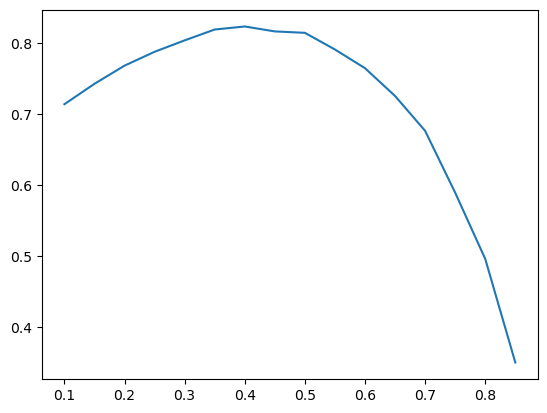

In [57]:
import numpy as np
import matplotlib.pyplot as plt
thresholds = np.arange(0.1, 0.9, 0.05) # 0.1부터 0.9까지 0.05 간격
f1s = []
for threshold in thresholds:
    y_pred = np.where(y_prob > threshold, 1, 0)
    f1 = f1_score(y_true, y_pred)
    f1s.append(f1)
    print(f'{threshold:.02f} {f1:.02f}')
plt.plot(thresholds, f1s)



그래서 우리가 예를 들면 나는 F1이 가장 높은 문턱값을 찾고 싶다

그러면 어떻게 하면 되냐면 문턱을 직접 바꿔보셔도 되는데 코드를 이렇게 짜가지고 0.1, 0.9, 0.05 이렇게 하면 0.1부터 0.9까지 0.05 간격으로 그래서 문턱값을 조금씩 조금씩 바꾸는 거예요

조금 조금씩 바꿔가지고 그때마다 F1을 계속 계산을 해서 여기다 이제 추가를 해주면 되겠죠

append 이러면 추가를 하라는 얘기입니다

그래서 이걸 이제 그래프로 그리면 문턱값이 0.45일 때 제일 높구나

뭐 이런 식으로 언제 문턱값이 제일 높은지가 나오겠죠

그래서 뭐 이렇게 수동으로 하셔도 되고 사실 아까처럼 아니면은 포문 코딩이 좀 익숙하시면 포문으로 짜서 문턱을 바꿔가면서 계속 계산을 다시 해가지고 이런 식으로 찾으시면 되겠죠

그래서 해보면은 여기가 이제 제일 높죠

그래서 언제가 제일 높은지 보니까는 한 지금 보니까 한 0.35에서 0.45 사이에서 제일 F1이 높게 나오는 거를 볼 수 있습니다 그러면은 이 어둠으로 문턱값을 정하면 되겠죠

우리가 F1을 높이는 게 목적이라면 F2가 0.35에서 0.35로 나와야 되죠

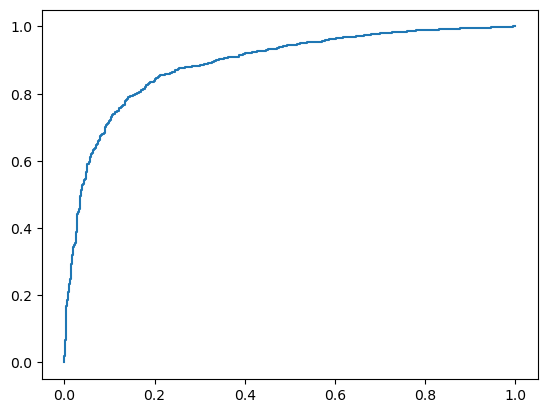

In [58]:
from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, threshold = roc_curve(y_true, y_prob)
plt.plot(fpr, tpr)

In [59]:
roc_auc_score(y_true, y_prob)

0.88977

그래서 우리가 이제 지금까지 지표를 여러 개 배웠는데 사실 지표가 되게 많아요

모든 지표를 위키백과에 있길래 제가 가져왔는데 이제 우리가 얘기한 게 지금 이 중에서 뭐입니까

여기 precision 하고 이게 이제 이게 이제 이게 특이도고 recall이 실제로 positive인 거 중에 이거니까 여기 있죠

recall recall 있고 우리 3개에다가 F1 4개를 했는데 사실 그 외에도 뭐 이걸 조합을 하면은 조합하기에 따라서 지표를 엄청나게 많이 만들 수 있습니다

제일 많이 쓰는 게 이제 요 4개인데 그 외에도 만들기에 따라서 이제 이렇게 이렇게 조합을 해 가지고 굉장히 다양한 지표들을 만들 수가 있겠죠

그래서 이런 식으로 이제 지표를 만드실 수가 있고 그 다음에 보면은 지표들이 보통 이제 방향이 두 가지에요

문턱을 올리는 거에 따라서 올라가는 지표가 있고 내려가는 지표가 있고 그렇거든요

그래서 이제 대체로 이제 두 방향으로 갈립니다

그래서 그거를 이용해서 이제 ROC 곡선이라는 걸 만드는데 ROC 곡선은 뭐냐면 FPR이라는 지표가 있고요 FPR이라는 지표가 있고요 FPR이라는 지표가 있고요

FPR은 어떻게 계산되냐면 1에서 특이도를 뺀 거예요

1- 특이도고 그 다음에 TPR이라는 지표가 있는데 TPR은 재현도랑 똑같은 겁니다

그래서 FPR 대 TPR 또는 1- 특이도 대 재현도 이렇게 계산하는데 특이도는 이제 문턱을 높이면은 올라가거든요

재현도는 문턱을 낮추면 올라가고 특이도는 문턱을 낮추면은 떨어집니다

그래서 여기가 이제 문턱이 낮은 지점이에요

문턱 낮음

그러니까 재현도가 높고 이게 1- 특이도라서 특이도가 이제 여기가 낮은 거예요

여기는 문턱이 높습니다

문턱이 높음

그러면 우리가 이제 문턱을 높은 데서 낮은 데까지 이렇게 바꿀 수가 있는데 그럼 지표들이 변하겠죠?

그거에 따라서 문턱에 따라 지표가 변하는데 만약에 이제 이런 식으로 직선 형태로 움직인다

그럼 그 얘기는 뭐냐면 재현도를 올리면 그만큼 특이도가 빠진다는 얘기 근데 만약에 커브가 이런 식으로 돼 있다 그러면은 재현도를 여기에서 여기까지 올렸는데 쫙 올렸는데 특이도가 빠지긴 빠지지만은 이만큼만 빠지죠

그래서 한 요 정도까지는 우리가 재현도를 많이 올려도 특이도가 별로 안 빠집니다

여기서부터 이제 많이 빠지는데 상당히 까지 빠지죠?

그러니까 특이도를 별로 손에 안 보고 재현도를 많이 올릴 수 있는 거죠

한 요 정도까지는 그래서 이게 많이 휘어 있으면 안쪽으로 이렇게 많이 휘어 있으면 많이 휘어 있을수록 우리가 이제 다른 지표를 별로 손에 안 보고 한 지표를 올릴 수가 있습니다

좀 자유가 생기는 거죠

우리가 이제 좀 더 마음대로 지표를 결정할 수 있는 겁니다

그래서 이제 이런 곡선을 ROC 곡선이라고 하는데요 이 곡선이 이렇게 볼륨이 있는 것이죠?

이쪽으로 갈수록 모델이 더 좋다고 할 수 있고 그래서 우리가 모델의 성능을 판정을 할 때 정확도라든가 특이도라든가 재현도라든가 이런 지표들은 문턱에 따라서 좌우되기 때문에 우리가 문턱을 문턱에 독립적으로 만드는 지표가 AUC라는 지표가 있습니다.

이 AUC 지표는 에어리어 면적 언더 아래의 더 커브 곡선 그래서 곡선 하 면적이라고 하는데 이 곡선 아래의 면적으로 모델의 성능을 측정하는 거예요.

그래서 이 곡선이 볼록하면 볼록할수록 이 아래쪽의 면적이 늘어나겠죠.

그래서 최대의 경우에 여기가 완전히 수직으로 꺾이는 경우인데 그때 면적이 1이 됩니다.

그래서 AUC를 계산해서 AUC가 높으면 그 모델이 좋은 모델이다.

이렇게 얘기하고 이렇게 되면 면적이 절반이니까 0.5가 되겠죠.

그래서 AUC가 0.5면 나쁜 모델이 됩니다.

AUC가 0.5 밑이면 그 모델은 쓰레기예요.

쓰레기.

왜냐하면 AUC가 0.5라는 거는 이게 커브가 이렇게 되는데 그럼 내가 높이는 것보다 더 많이 빠지는 거거든요.

하나의 지표를 올리면 다른 지표는 하나의 지표를 0.1 올리면 다른 지표는 0.2가 빠지고 이런 식입니다.

쓰레기죠.

뭔 그런 그래서 0.5인 거가 거의 하한이고 사실 0.5도 AUC가 0.5가 나오는 모델은 만들기 되게 쉬워요.

뭐냐면 문 닫고 찍으면 0.5가 됩니다.

그러니까 AUC가 0.5보다 밑이다.

그럼 문 닫고 찍는 것보다 못하다는 거예요.

반대로 간다는 얘기죠.

그래서 실질적으로는 AUC가 0.5에서 1 사이 이론적으로는 0에서 1 사이인데 0.5 밑은 쓰레기니까 거기 있는 논할 것도 없고 0.5보다는 높아야 되고 당연히 1보다는 보통 밑인데 1에 가까울수록 좋은 그런 지표가 됩니다.

그래서 이것도 계산을 해보면 계산을 해보면 플롯을 그려보면 이렇게 되고요.

그래도 우리 모델을 보면 상당히 볼록한 편이죠.

그래서 꽤 좋다는 걸 알 수 있고 그 다음에 AUC를 계산해 보면 한 80-90% 정도 나올 겁니다.

면적이 0.8에서 0.9 정도 나올 건데 그래서 우리가 모델을 만들고 그 모델을 만들고 그 모델을 만들고 그 모델을 만들고 그 모델을 만들고 그 모델을 만들고 그 모델을 만들고 그 모델을 만들고 그 모델을 만들고 그 모델을 만들고 그 모델을 만드는 데 그 모델을 만드는 데 한 1시간 정도 배우고 만든 건데 그렇게 나쁘진 않다.

조금만 더 배우면 이것도 굉장히 높일 수 있습니다.

사실 패션 앱 리스트도 그렇게 어려운 데이터는 아니라는 거죠.

이렇게 해서 우리가 어떤 모델을 진단하는 이 모델이 잘 만들어졌나 안 만들어졌나 이걸 진단하는 여러 가지 지표들을 배워봤는데요.

한 번에 지표들을 너무 많이 배워서 정신이 처음 들으시면 머리가 복잡해지고 머리가 복잡해지고 머리가 복잡해지고 이건 조금 복잡한데 이거는 외우지 마시고 그때그때 찾아보시면서 하시면 됩니다.

이게 문턱을 높이면 올라가던가 내려가던가 이게 문턱을 높이면 올라가던가 내려가던가 근데 우리가 다 찾아보면 있는 거니까 강의 자료에도 있고요 그래서 외우지 마시고 지표들이 많구나

이 정도만 기억을 하셔도 되겠다
